##Import Training Data

In [ ]:
https://drive.google.com/file/d/1VQXRATWQS8hAafZcSwxs-BawcLuD1w2L/view?usp=sharing
! gdown 1VQXRATWQS8hAafZcSwxs-BawcLuD1w2L
!unzip MPAA_1.zip

##CS Capstone Model
In this section I import and augment the data to match my model. I also build, train, and evaluate the model here.
This model is to determine the MPAA age-group of a face using a CNN archictecture to perform a feature-classification analysis.


###Import dependencies and prepare environment

Pandas, Numpy, Path, OpenCV(cv2)

In [ ]:
import pandas as pd

import numpy as np
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

#enumerate MPAA age-groups
def enumerate_age_groups(group):
    if group == 'PG':
        return 0
    elif group == 'PG13':
        return 1
    elif group == 'R':
        return 2

image_dir = Path('./MPAA/')
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)

ages = pd.Series(filepaths.apply(lambda x: enumerate_age_groups(os.path.split(os.path.split(x)[0])[1])), name='MPAA-Group')

images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [ ]:
images

,Filepath,MPAA-Group
0,MPAA/R/29_1_2_20170116163132225.jpg.chip.jpg,2
1,MPAA/R/21_0_0_20170113182733390.jpg.chip.jpg,2
2,MPAA/R/32_0_0_20170114034605240.jpg.chip.jpg,2
3,MPAA/R/32_0_1_20170117182408963.jpg.chip.jpg,2
4,MPAA/PG/4102.jpg,0
...,...,...
19264,MPAA/R/25_1_4_20170103225922392.jpg.chip.jpg,2
19265,MPAA/PG/9_0_0_20170110224627443.jpg.chip.jpg,0
19266,MPAA/R/20_1_3_20170104231528577.jpg.chip.jpg,2
19267,MPAA/R/18_1_1_20170114030424059.jpg.chip.jpg,2


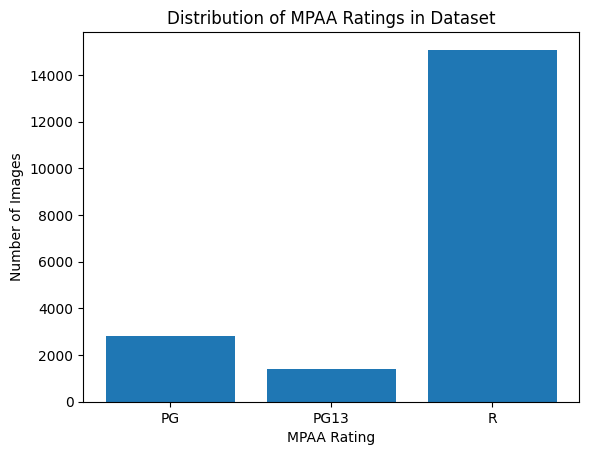

In [ ]:
# prompt: plot images distribution with labels mapped to enumerate_age_groups()

import matplotlib.pyplot as plt
age_counts = images.groupby('MPAA-Group').size()
labels = ['PG', 'PG13', 'R']
plt.bar(labels, age_counts)
plt.xlabel('MPAA Rating')
plt.ylabel('Number of Images')
plt.title('Distribution of MPAA Ratings in Dataset')
plt.show()


###Build Train/Test Generators and Data Frames

In [ ]:
train_df, test_df = train_test_split(images, train_size=0.9, shuffle=True, random_state=1)

train_aug_filenames_list = list(train_df['Filepath'])
train_aug_labels_list = list(train_df['MPAA-Group'])

test_filenames_list = list(test_df['Filepath'])
test_labels_list = list(test_df['MPAA-Group'])

train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

num_classes = 3

def _parse_function(filename, label):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
train_aug_dataset = train_aug_dataset.batch(128)

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(128)



###Build the CNN structure

In [ ]:
# Defining the architecture of the sequential neural network.

model = Sequential()

# Input layer with 32 filters, followed by an AveragePooling2D layer.
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 3)))    # 3rd dim = 1 for grayscale images.
model.add(AveragePooling2D(pool_size=(2,2)))

# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))

# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
model.add(GlobalAveragePooling2D())

# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
model.add(Dense(132, activation='relu'))

# Output layer with 7 nodes (equal to the no. of classes).
model.add(Dense(3, activation='softmax'))

model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Creating a ModelCheckpoint callback object to save the model according to the value of val_accuracy.

checkpoint = ModelCheckpoint(filepath=f"./MPAA_cnn_model_checkpoint.keras",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 average_pooling2d (Average  (None, 99, 99, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_1 (Avera  (None, 48, 48, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_2 (Avera  (None, 23, 23, 128)       0

##Model Training
Will take about 30 mins using GPU




In [ ]:
#Model fitting
history = model.fit(
    train_aug_dataset,
    batch_size=128,
    validation_data=test_dataset,
    epochs=60,
    callbacks=[
        checkpoint
    ]
)

Epoch 1/60
136/136 [==============================] - ETA: 0s - loss: 1.2271 - accuracy: 0.7692
Epoch 1: val_accuracy improved from -inf to 0.79294, saving model to ./MPAA_cnn_model_checkpoint.keras
136/136 [==============================] - 24s 104ms/step - loss: 1.2271 - accuracy: 0.7692 - val_loss: 0.6195 - val_accuracy: 0.7929
Epoch 2/60
135/136 [============================>.] - ETA: 0s - loss: 0.6625 - accuracy: 0.7821
Epoch 2: val_accuracy did not improve from 0.79294
136/136 [==============================] - 11s 84ms/step - loss: 0.6627 - accuracy: 0.7820 - val_loss: 0.6089 - val_accuracy: 0.7914
Epoch 3/60
135/136 [============================>.] - ETA: 0s - loss: 0.6133 - accuracy: 0.7867
Epoch 3: val_accuracy improved from 0.79294 to 0.80955, saving model to ./MPAA_cnn_model_checkpoint.keras
136/136 [==============================] - 11s 84ms/step - loss: 0.6133 - accuracy: 0.7869 - val_loss: 0.5599 - val_accuracy: 0.8095
Epoch 4/60
135/136 [============================>.] 

## Model Evaluation

In [ ]:
predicted_enums = model.predict(test_dataset)
predicted_enums = predicted_enums.argmax(axis=-1)
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
conf_mat = confusion_matrix(test_labels_list, predicted_enums)
conf_mat

16/16 [==============================] - 1s 35ms/step


array([[ 267,    4,   12],
       [  25,   80,   14],
       [  89,   42, 1394]])

###Confusion Matrix

Normalized confusion matrix


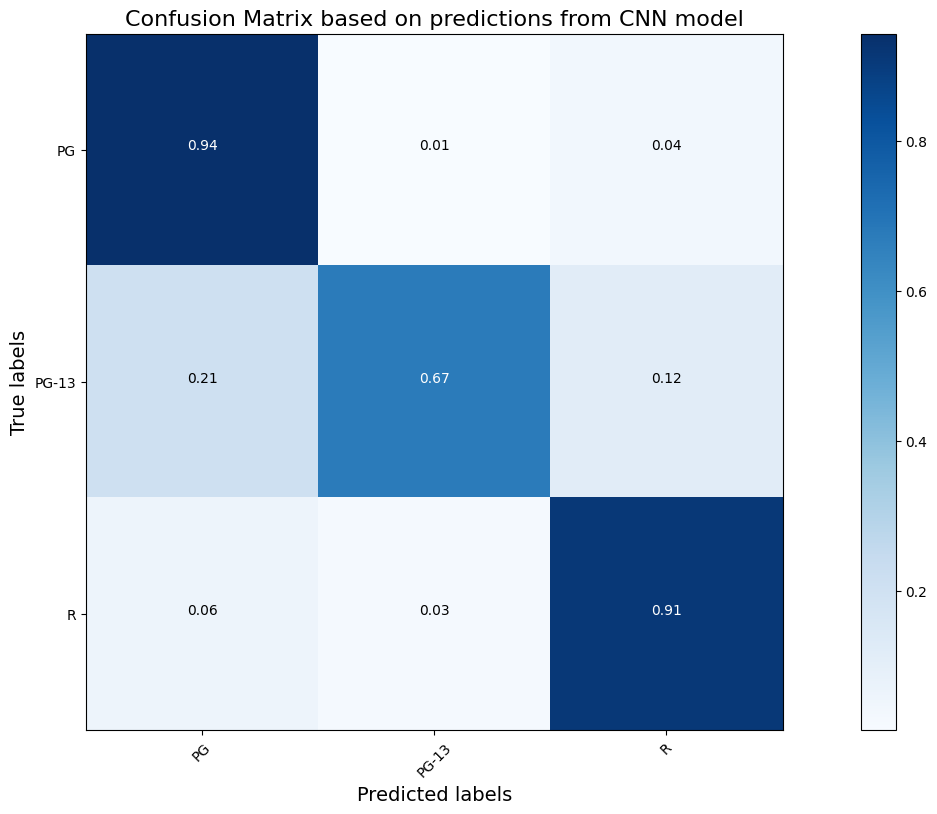

In [ ]:


# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'{export_as}.png', bbox_inches='tight');


cm_plot_labels = ['PG', 'PG-13', 'R']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )

plt.show()

###Training vs Test Loss and Accuracy

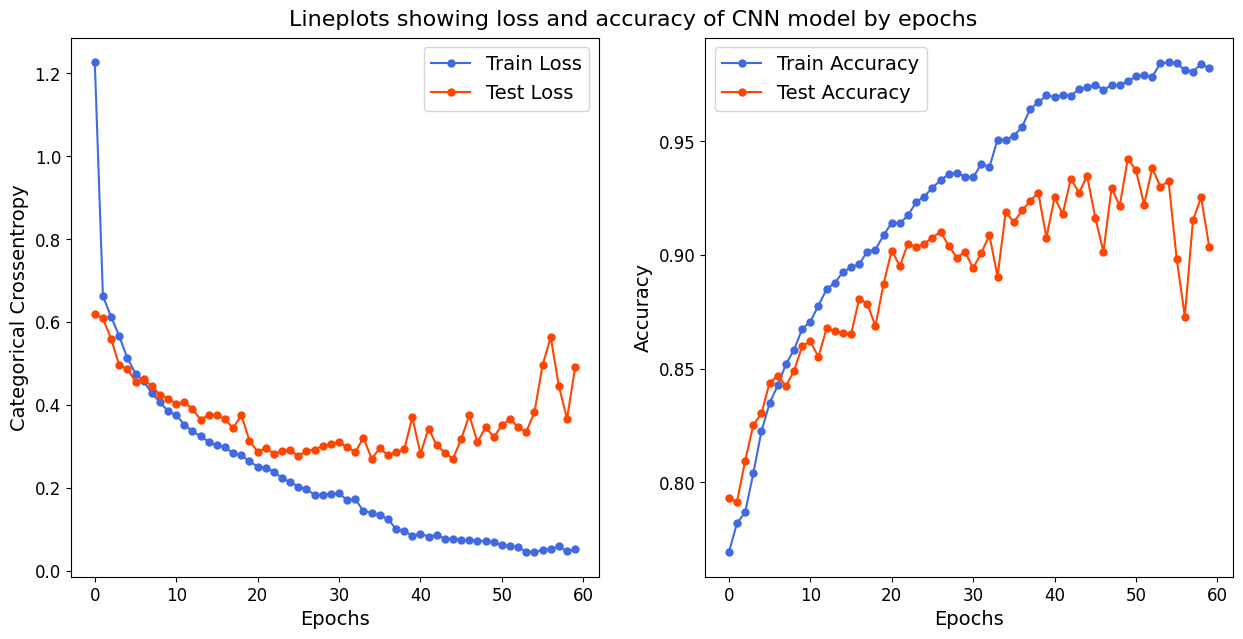

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('final_cnn_loss_accuracy.png', bbox_inches='tight');